## Set-Up

In [ ]:
#!pip install torch torchvision timm SimpleITK nibabel numpy scipy matplotlib scikit-learn monai pycairo einops tqdm
#!pip install git+https://github.com/DIAGNijmegen/Tiger.git@stable

import os
from tqdm import tqdm
import multiprocessing as mp
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from timm.models.swin_transformer import SwinTransformer #Swin Transformer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


from monai.networks.nets import SwinUNETR
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ScaleIntensity, Spacing, DivisiblePad, Activations, AsDiscrete
from monai.inferers import sliding_window_inference
from monai.transforms import LoadImage, Compose, Activations, AsDiscrete
from monai.metrics import DiceMetric, DiceHelper

### Download Images and Masks

In [2]:
#brew install wget
#brew install unzip
# !wget https://zenodo.org/api/records/10159290/files-archive -O data.zip
# !unzip data.zip
# !unzip data/images.zip -d data/extracted_images
# !unzip data/masks.zip -d data/extracted_masks

### Download Initial Weights

In [ ]:
# Download pre-trained SwinUNETR
#!wget https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt

# Data Preparation

### Find Images and Get Metadata

In [3]:
# Base directories for images and masks
image_base_dir = "../../extracted_images/images"
mask_base_dir = "../../extracted_images/masks"

image_files = []
mask_files = []

# Find all the files in the extracted directory
for root, _, files in os.walk(image_base_dir):
    for file in files:
        if file.endswith('.mha'):
            image_files.append(os.path.join(root, file))

# Find all mask files in the extracted directory
for root, _, files in os.walk(mask_base_dir):
    for file in files:
        if file.endswith('.mha'):
            mask_files.append(os.path.join(root, file))

image_mask_pairs = list(zip(image_files[:10], mask_files[:10]))
for image_file, mask_file in image_mask_pairs:
    if os.path.basename(image_file) == os.path.basename(mask_file):
        continue
    else:
        print("mismatched files")

# Update the paths in image_mask_pairs
image_mask_pairs = [
    (os.path.join(image_base_dir, os.path.basename(pair[0])),
    os.path.join(mask_base_dir, os.path.basename(pair[1])))
    for pair in image_mask_pairs
]

In [ ]:
data = []
for image_path in image_mask_pairs:
    image = sitk.ReadImage(image_path)
    info = {
        "spacing": image.GetSpacing(),
        "origin": image.GetOrigin(),
        "size": image.GetSize()
    }
    data.append(info)

# Ensure min_spacing matches the number of dimensions
num_dimensions = len(data[0]["spacing"])
min_spacing = [float("inf")] * num_dimensions

# Iterate through all images to find the minimum spacing
for info in data:
    spacing = info["spacing"]
    min_spacing = [min(min_spacing[i], spacing[i]) for i in range(num_dimensions)]

print(f"Minimum spacing across all images: {min_spacing}")

Minimum spacing across all images: [0.5859375, 0.5859375, 0.38792314385787563, 3.4809342861069267e-14]


### Resample Images

In [16]:
def isotropic_resample(image, min_spacing, interpolator):
    # Get original size and spacing
    original_size = image.GetSize()
    original_spacing = image.GetSpacing()

    # Compute new size
    new_size = [
        int(round(original_size[i] * (original_spacing[i] / min_spacing[i])))
        for i in range(len(min_spacing))
    ]

    # Resample
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(min_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetInterpolator(interpolator)

    return resampler.Execute(image)


#directory to save resampled images and masks
output_image_directory = "../../../data/isotropic_images"
output_mask_directory = "../../../data/isotropic_masks"
os.makedirs(output_image_directory, exist_ok=True)
os.makedirs(output_mask_directory, exist_ok=True)

# Resample each image and mask
for image_path, mask_path in image_mask_pairs:
    # Read image and mask
    image = sitk.ReadImage(image_path)
    mask = sitk.ReadImage(mask_path)

    # Resample image (linear interpolation)
    resampled_image = isotropic_resample(image, [0.5, 0.5, 0.5], sitk.sitkLinear)

    # Resample mask (nearest-neighbor interpolation)
    resampled_mask = isotropic_resample(mask, [0.5, 0.5, 0.5], sitk.sitkNearestNeighbor)

    # Save resampled image
    image_file_name = os.path.basename(image_path)
    output_image_path = os.path.join(output_image_directory, f"isotropic_{image_file_name}")
    sitk.WriteImage(resampled_image, output_image_path)

    # Save resampled mask
    mask_file_name = os.path.basename(mask_path)
    output_mask_path = os.path.join(output_mask_directory, f"isotropic_{mask_file_name}")
    sitk.WriteImage(resampled_mask, output_mask_path)

print(f"Resampled images saved to: {output_image_directory}")
print(f"Resampled masks saved to: {output_mask_directory}")

Resampled images saved to: ../../../data/isotropic_images
Resampled masks saved to: ../../../data/isotropic_masks


# Visualization

## Intialize Parameters and Model

In [418]:
# Define patch size and stride
patch_size = (64, 64, 64)
stride = (32, 32, 32)
spacing = (2.0, 2.0, 2.0)

label_mapping = {
    0: 0,  # Background
    1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9,  # Vertebrae
    100: 10,  # Spinal Canal
    201: 11, 202: 12, 203: 13, 204: 14, 205: 15, 206: 16, 207: 17, 208: 18, 209: 19  # IVDs
}
num_classes = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = SwinUNETR(
    img_size=patch_size,
    in_channels=1,
    out_channels=num_classes,
    feature_size=48,
    use_checkpoint=True,
).to(device)

# Load the checkpoint
checkpoint = torch.load("./model_2direct_best.pth", map_location=device, weights_only=True)

# Pass the checkpoint directly to load_from
model.load_state_dict(checkpoint)  # No need for "state_dict"
# model.load_from(checkpoint)  # No need for "state_dict"
# model.eval()  # Set the model to evaluation mode

<All keys matched successfully>

## Preprocess Image

In [ ]:
# Preprocessing transforms
preprocess = Compose([
    EnsureChannelFirst(),  # Ensure channel-first format
    ScaleIntensity(minv=0.0, maxv=1.0),  # Normalize intensity
    Spacing(pixdim=spacing, mode="bilinear"),  # Resample to target spacing
    DivisiblePad(patch_size[0]*0.5, mode="constant")  # Pad to the desired patch size
])

# Load and preprocess the image
loader = LoadImage(image_only=True, reader="ITKReader")  # Load the full image
image = loader(image_mask_pairs[0][0])
preprocessed_image = preprocess(image)  # Shape: [C, D, H, W]

# Convert to tensor and move to the appropriate device
input_tensor = torch.tensor(preprocessed_image, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

# Perform sliding window inference
with torch.no_grad():
    outputs = sliding_window_inference(
        inputs=input_tensor,  # Full input image
        roi_size=patch_size,  # Size of each patch
        sw_batch_size=1,  # Number of patches to process in parallel
        predictor=model,  # Model to use for inference
        overlap=0.5,
        mode="constant"
    )

## Postprocessing

In [ ]:
# Postprocessing transforms
post_transforms = Compose([
    Activations(softmax=True),  # Convert logits to probabilities
    AsDiscrete(argmax=True, to_onehot=20)  # Get the class with the highest probability
])

# Apply postprocessing to the model's output
segmentation = post_transforms(outputs.squeeze(0))  # Remove batch dimension and move to CPU
segmentation_classes = torch.argmax(segmentation, dim=0).unsqueeze(0)
print(segmentation_classes.shape)
print(np.unique(segmentation_classes))

torch.Size([1, 64, 160, 160])
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


## Plot Images, Ground Truth Mask, and Predicted Mask

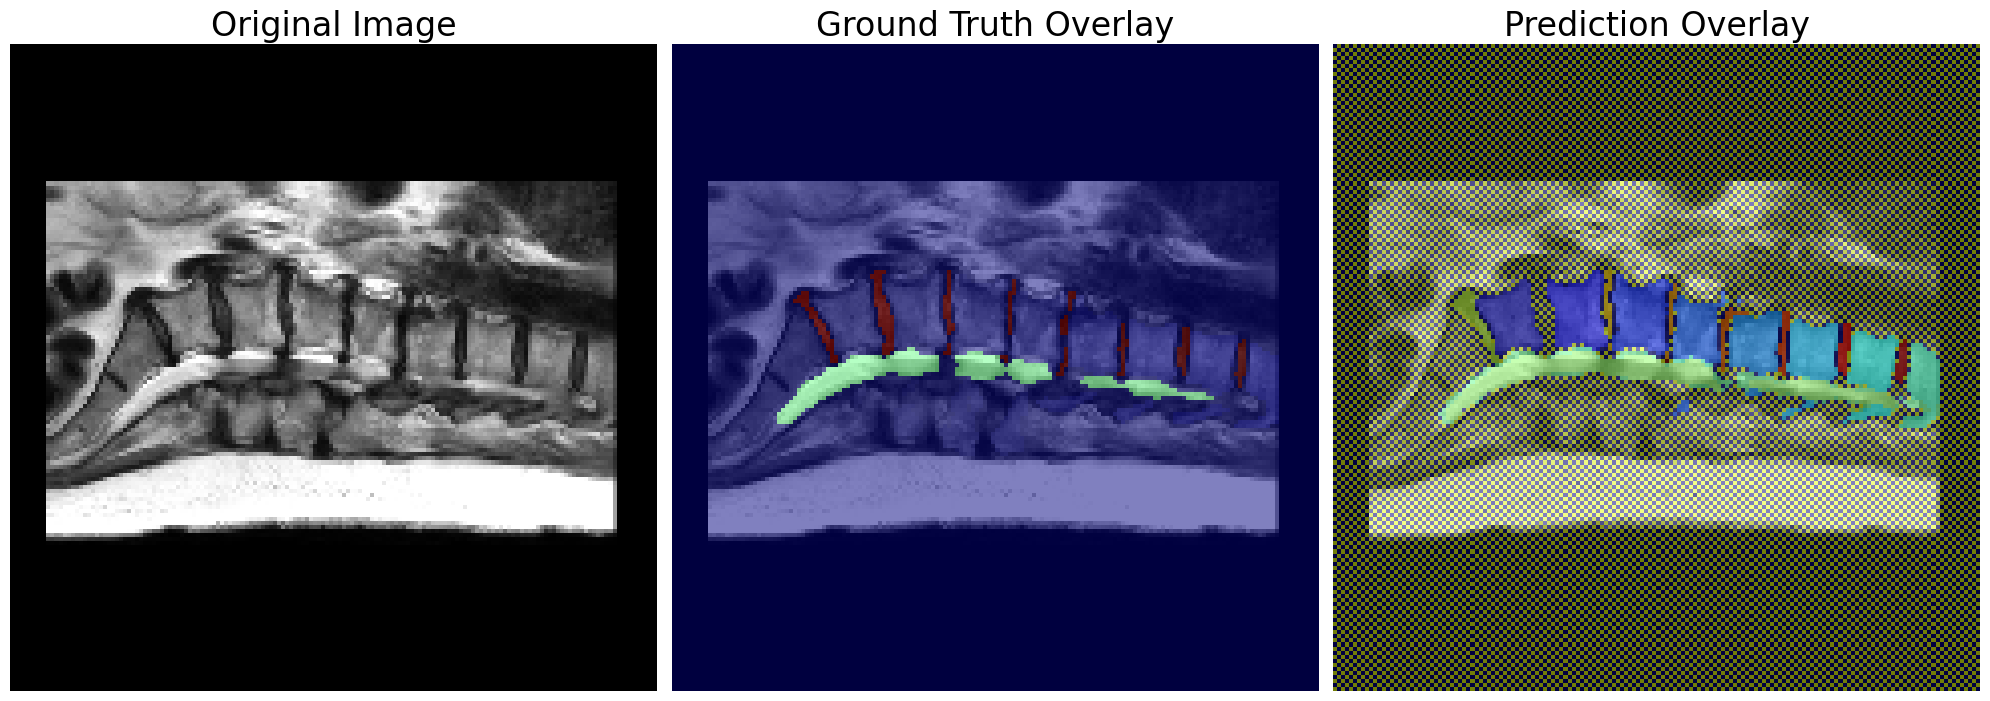

In [ ]:
# Define paths
mask_path = image_mask_pairs[0][1]  # Path to the dataset mask

# Process ground truth mask
process_ground_truth = Compose([
    EnsureChannelFirst(),
    Spacing(pixdim=spacing, mode="nearest"),  # Resample to target spacing
    DivisiblePad(patch_size[0]*0.5, mode="constant")
])

# Load the dataset mask
dataset_mask = loader(mask_path)  # Load the dataset mask
dataset_mask_array = np.array(process_ground_truth(dataset_mask))  # Convert to NumPy array

# Extract slices
slice_index = preprocessed_image.numpy().shape[1] // 2 # Middle slice of image
preprocessed_image_slice = preprocessed_image[0, slice_index, :, :]
dataset_mask_slice = dataset_mask_array[0, slice_index, :, :]  # Middle slice of the dataset mask
predicted_mask_slice = segmentation_classes[0, slice_index, :, :]  # Shape [H, W]

# Plot all three visualizations
plt.figure(figsize=(20, 10))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image", fontsize=24)
plt.imshow(preprocessed_image_slice, cmap="gray")
plt.axis("off")

# Dataset Mask Overlaid
plt.subplot(1, 3, 2)
plt.title("Ground Truth Overlay", fontsize=24)
plt.imshow(preprocessed_image_slice, cmap="gray")  # Grayscale image
plt.imshow(dataset_mask_slice, cmap="jet", alpha=0.5)  # Overlay dataset mask
plt.axis("off")

# Output Mask Overlaid
plt.subplot(1, 3, 3)
plt.title("Prediction Overlay", fontsize=24)
plt.imshow(preprocessed_image_slice, cmap="gray")  # Grayscale image
plt.imshow(predicted_mask_slice, cmap="jet", alpha=0.5)  # Overlay output mask
plt.axis("off")

plt.tight_layout()
plt.show()

## Computing Mean Dice Score

In [ ]:
# Label mapping
label_mapping = {
    0: 0,  # Background
    1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9,  # Vertebrae
    100: 10,  # Spinal Canal
    201: 11, 202: 12, 203: 13, 204: 14, 205: 15, 206: 16, 207: 17, 208: 18, 209: 19  # IVDs
}

# Apply label mapping
ground_truth_mask = np.vectorize(label_mapping.get)(dataset_mask_array)
ground_truth_mask = torch.tensor(ground_truth_mask)

# Apply post processing to predicted mask
predicted_mask = post_transforms(outputs.squeeze(0))

# Compute DICE metric
dice_metric = DiceMetric(include_background=True, reduction="mean", num_classes=-1)
dice_score = dice_metric(
    torch.tensor(predicted_mask.unsqueeze(0)),  # Add batch dimension
    torch.tensor(ground_truth_mask.unsqueeze(0)),  # Add batch dimension
)
dice_score_mean = dice_score.mean().item()
dice_metric.reset()

# Print DICE score
print(f"DICE score: {dice_score_mean:.4f}")

DICE score: 0.8525


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
# List of saved .npz files for different folds
# files = [f"4_{num}_metrics.npz" for num in range(1, 6)]
files =["4_2_metrics.npz", "2d_1_metrics.npz", "2_1_metrics.npz"]
# Initialize variables to store highest Dice scores
highest_dice_scores = []

for file in files:
    # Load metrics from file
    data = np.load(file)

    # Retrieve Dice scores
    dice_scores = data["val_dice_scores"]

    # Find the highest Dice score for the fold
    highest_dice = np.max(dice_scores)
    highest_dice_scores.append(highest_dice)

    print(f"Highest Dice Score for {file}: {highest_dice:.4f}")

# Find the overall highest Dice score across all folds
overall_highest_dice = np.max(highest_dice_scores)
print(f"Overall Highest Dice Score: {overall_highest_dice:.4f}")

Highest Dice Score for 4_2_metrics.npz: 0.2039
Highest Dice Score for 2d_1_metrics.npz: 0.2140
Highest Dice Score for 2_1_metrics.npz: 0.2449
Overall Highest Dice Score: 0.2449


## Plot Dice Loss

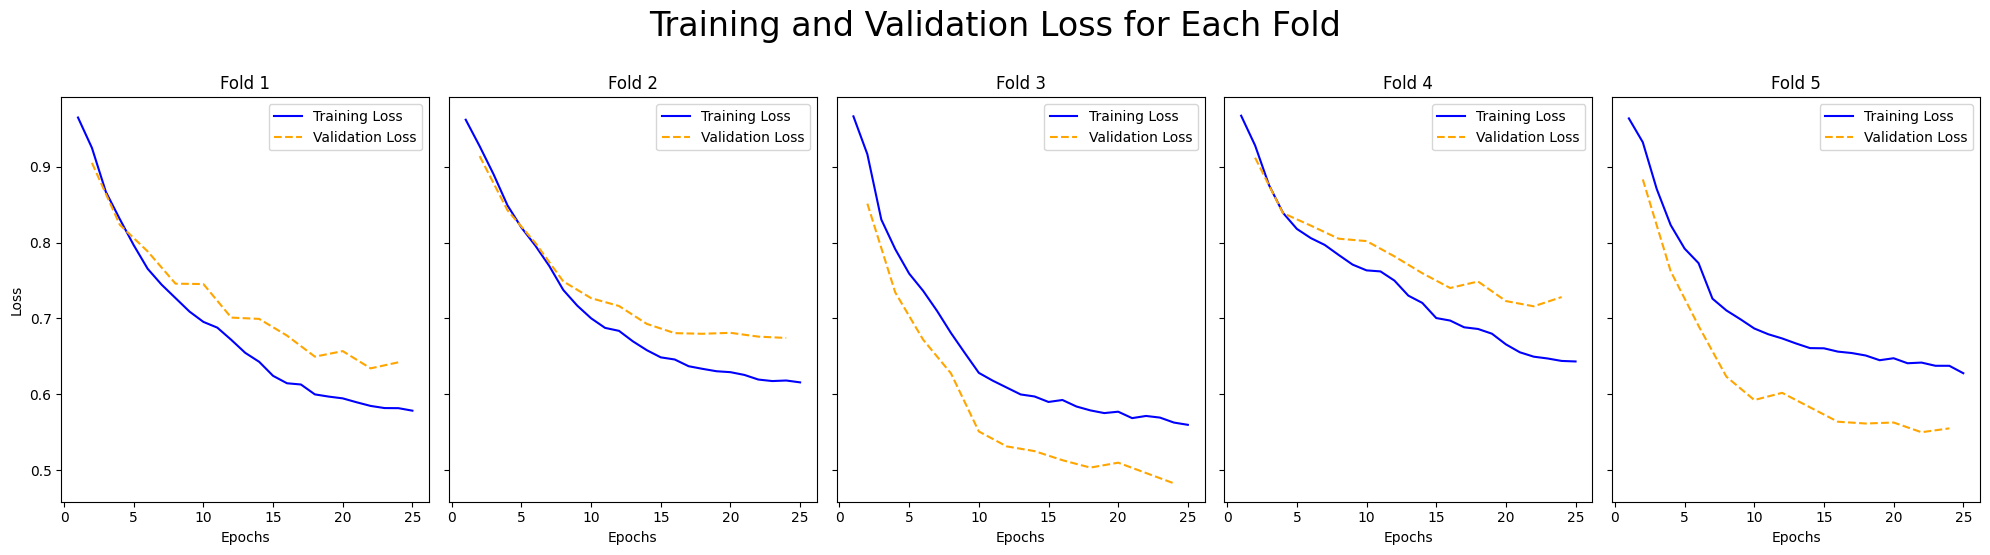

In [ ]:
# Paths to the saved .npz files
files = [f"4_{num}_metrics.npz" for num in range(1, 6)]  # Adjust range as needed

# Initialize lists to store metrics
fold_train_losses = []
fold_val_losses = []

# Load metrics for each fold
for file in files:
    data = np.load(file)
    fold_train_losses.append(data["train_losses"])
    fold_val_losses.append(data["val_losses"])

# Number of folds
num_folds = len(files)

# Create subplots: one row, multiple columns for each fold
fig, axes = plt.subplots(1, num_folds, figsize=(20, 5), sharey=True)

# Plot training and validation loss for each fold
for i in range(num_folds):
    epochs_train = range(1, len(fold_train_losses[i]) + 1)  # Training epochs
    val_interval = 2
    epochs_val = range(val_interval, len(fold_val_losses[i]) * val_interval + 1, val_interval)

    
    # Plot on the corresponding subplot
    axes[i].plot(epochs_train, fold_train_losses[i], label="Training Loss", color="blue")
    axes[i].plot(epochs_val, fold_val_losses[i], label="Validation Loss", linestyle="--", color="orange")
    
    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xlabel("Epochs")
    if i == 0:  # Set y-axis label only on the first subplot
        axes[i].set_ylabel("Loss")
    axes[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.suptitle("Training and Validation Loss for Each Fold", y=1.1, fontsize=24)
plt.show()